# Preprocess an image

*This notebook prepares images of vases for the image recognition process.*  

*The function `multiply_image` is based on the code Chris Birchall used to [find Wally](https://tech.ovoenergy.com/cheating-at-wheres-wally/).*  

*The function leverages `opencv` functionality to automatically detect image size (per [this resource](https://note.nkmk.me/en/python-opencv-pillow-image-size/)).*

In [1]:
# import necessary libraries
import cv2
import glob
import os.path
import pandas as pd
import numpy as np
from varname import nameof

### Write functions to cut up each image into multiple equally-sized, square chunks

*Since we don't know **if** there is a kithara in the image, nor if there is one **how big** it might be:*
* Identify the decile and quartile breakdowns of the proportion of image width and height that kitharai take up on the labeled dataset
* Based on a square box sized to the 25th, 50th, and 75th percentile of the `proportion of image width * total image width` and `proportion of image height * total image height`, chop each image up starting from the top left (`multiply_image`) corner
* Shift the x and y start coordinates by 1/2 of the calculated image box size at a time

*To clean up the data generated:*
* Save cropped images where the x and y axis are the same length (i.e. remove 'remainder' images)
* Resize all of the square images to the same dimensions (specifically, upscale and downscale images to 558 pixels - the size of the training images)

### Analysis of kithara sizes in proportion to image sizes

In [2]:
# import matplotlib for data visualization
import matplotlib.pyplot as plt
# set display options
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
# read in the CSV with the image sizes and kithara sizes
kitharai = pd.read_csv('../data/kithara_listing.csv')
# show descriptive stats
kitharai.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683 entries, 0 to 682
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   kithara_type    683 non-null    object 
 1   image           683 non-null    object 
 2   image_width     372 non-null    object 
 3   image_height    368 non-null    float64
 4   kithara_type.1  368 non-null    object 
 5   kithara_width   368 non-null    float64
 6   kithara_height  368 non-null    float64
 7   notes           228 non-null    object 
dtypes: float64(3), object(5)
memory usage: 42.8+ KB


In [4]:
# clean up rows that have a '?' instead of a number
kitharai = kitharai.drop(kitharai.index[345:349])
# check to make sure the data are cleaned
kitharai.loc[344:]

,kithara_type,image,image_width,image_height,kithara_type.1,kithara_width,kithara_height,notes
344,"2_(AU),2_(TYM),1_(AKI)",IMAG2764.jpg,7680,8496.0,AKI,173.0,248.0,being played
349,1_(CHYL),IMAG5979.jpg,7680,8160.0,CHYL,774.0,1098.0,being played
350,1_(CHYL),IMAG5980.jpg,7680,8256.0,CHYL,546.0,873.0,being played
351,1_(CHYL),IMAG5981.jpg,NaN,NaN,NaN,NaN,NaN,NaN
352,1_(CHYL),IMAG5991.jpg,7680,8928.0,CHYL,906.0,1104.0,being played
353,1_(CHYL),IMAG5992.jpg,NaN,NaN,NaN,NaN,NaN,NaN
354,1_(CHYL),IMAG5993.jpg,NaN,NaN,NaN,NaN,NaN,NaN
355,1_(CHYL),IMAG5994.jpg,10512,7680.0,CHYL,2484.0,3016.0,being played
356,1_(CHYL),IMAG5995.jpg,NaN,NaN,NaN,NaN,NaN,NaN
357,1_(CHYL),IMAG5996.jpg,7680,10368.0,CHYL,1316.0,1316.0,being played


In [5]:
# convert the previously-questionable rows to numbers
kitharai['image_height'] = pd.to_numeric(kitharai['image_height'])
kitharai['image_width'] = pd.to_numeric(kitharai['image_width'])
# create new columns with the labeled kithara width and height proportions compared to the full image dimensions
kitharai['width_proportion'] = kitharai.kithara_width / kitharai.image_width
kitharai['height_proportion'] = kitharai.kithara_height / kitharai.image_height

#### Take a look at the distribution of sizes and proportions

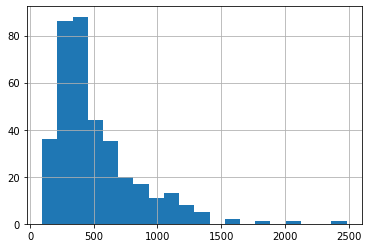

In [6]:
kitharai.kithara_width.hist(bins = 20);

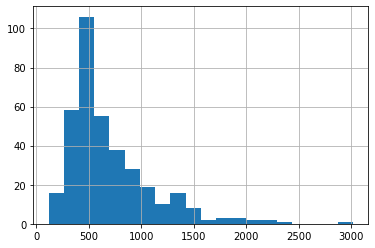

In [7]:
kitharai.kithara_height.hist(bins = 20);

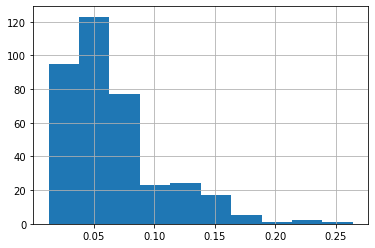

In [8]:
kitharai.width_proportion.hist(bins = 10);

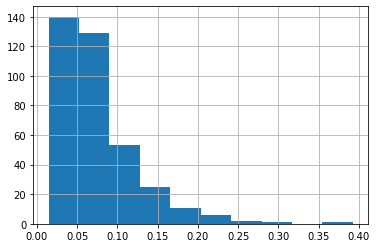

In [9]:
kitharai.height_proportion.hist(bins = 10);

*To normalize for the wide range of kithara and image sizes across the dataset, let's use the kithara:image width and height proportions.*

In [10]:
print(kitharai.height_proportion.describe())
print(kitharai.width_proportion.describe())

count    368.000000
mean       0.076610
std        0.047511
min        0.014323
25%        0.047212
50%        0.061202
75%        0.093640
max        0.392708
Name: height_proportion, dtype: float64
count    368.000000
mean       0.065725
std        0.039636
min        0.012891
25%        0.037402
50%        0.055143
75%        0.081055
max        0.264062
Name: width_proportion, dtype: float64


In [11]:
# identify the %s at ever 5%
_, hbins20 = pd.qcut(kitharai['height_proportion'], q = 20, retbins = True)
_, wbins20 = pd.qcut(kitharai['width_proportion'], q = 20, retbins = True)

In [12]:
print('height 5% bins:')
print(hbins20)
print('width 5% bins:')
print(wbins20)

height 5% bins:
[0.01432292 0.02997963 0.03386193 0.04050041 0.04420737 0.04721232
 0.04878881 0.0506787  0.05326455 0.05661106 0.06120242 0.06670755
 0.07270833 0.07707344 0.08455025 0.09363996 0.10388565 0.11936288
 0.13705848 0.16973958 0.39270833]
width 5% bins:
[0.01289062 0.02382812 0.02795573 0.03152054 0.034375   0.03740234
 0.04010417 0.04409082 0.04828125 0.05108073 0.05514323 0.05801432
 0.06416667 0.06875    0.07471354 0.08105469 0.08765625 0.10276042
 0.11984522 0.14979167 0.2640625 ]


*Based on the quartile and decile breakdowns of kithara `width_proportion` and `height_proportion`, the %s used will be:*
* 10th %ile h: 3.4%, w: 2.8%, average: 3.1%
* 25th %ile h: 4.7%, w: 3.7%, average: 4.2%
* 50th %ile h: 6.1%, w: 5.5%, average: 5.8%
* 75th %ile h: 9.4%, w: 8.1%, average: 8.8%
* 90th %ile h: 13.7%, w: 12%, average: 12.9%

#### Define `multiply_image` function

*Scan over the image, from top left, and chop it into multiple equal-sized squares based on the %ile size. Save only square boxes (i.e. remove remainders).*

In [13]:
# for each image in the folder
# get the height and width of each image
# iterate over the image and create equally-sized pixel squares
# resize the images to the model input size
# write cropped images out to separate folders

def multiply_image(name):
    # read in the image
    img = cv2.imread("../data/test/{}.jpg".format(name))
    # get the size of the image
    y_max, x_max, _ = img.shape
    # calculate %ile sizes
    y_size10 = int(y_max * 0.034375)
    y_size25 = int(y_max * 0.047212)
    y_size50 = int(y_max * 0.061202)
    y_size75 = int(y_max * 0.093640)
    y_size90 = int(y_max * 0.13705848)
    x_size10 = int(x_max * 0.02795573)
    x_size25 = int(x_max * 0.037402)
    x_size50 = int(x_max * 0.05514323)
    x_size75 = int(x_max * 0.081055)
    x_size90 = int(x_max * 0.11984522)
    # set the image size based on the larger of x or y
    size10 = np.where(x_size10 > y_size10, x_size10, y_size10).item(0)
    size25 = np.where(x_size25 > y_size25, x_size25, y_size25).item(0)
    size50 = np.where(x_size50 > y_size50, x_size50, y_size50).item(0)
    size75 = np.where(x_size75 > y_size75, x_size75, y_size75).item(0)
    size90 = np.where(x_size90 > y_size90, x_size90, y_size90).item(0)
    # set variable with sizes
    sizes = [size10, size25, size50, size75, size90]
    for size in sizes:
        # set the increment to 1/2 the size of the larger of x or y length for the kithara
        inc = int(size/2)
        # incrementally move forward, starting at the top L corner, by 1/2 the largest dimension of the kithara size
        # get a bunch of square images that are the size of the kithara (or smaller, if running into an edge)
        for y in range(0, y_max, inc):
            if y + size <= y_max:
                start_y = y
                end_y = y + size
            else:
                start_y = y
                end_y = y_max            
            for x in range(0, x_max, inc):
                if x + size <= x_max:
                    start_x = x
                    end_x = x + size
                else:
                    start_x = x
                    end_x = x_max
                # create the cropped image based on the coordinates set above
                cropped_img = img[start_y:end_y, start_x:end_x]
                if (end_y - start_y) == (end_x - start_x):
                    # create a variable to tell the function how much to scale the original up/down to 558x558 pixesl
                    scale_percent = 558 / (cropped_img.shape[0])
                    # create new dimensions tuple
                    width = int(cropped_img.shape[1] * scale_percent)
                    height = int(cropped_img.shape[0] * scale_percent)
                    dim = (width, height)
                    # resize the image
                    cropped_img = cv2.resize(cropped_img, dim, interpolation = cv2.INTER_AREA)
                    # write the resized image out
                    cv2.imwrite("../data/test/processed/{}-{}-{}-{}.jpg".format(name, size, start_y, start_x), cropped_img)

#### Run the function over the image test data

In [14]:
# run the functions over the image folder    
for path in glob.glob("../data/test/*.jpg"):
    name = os.path.splitext(os.path.basename(path))[0]
    multiply_image(name)